# Generating Faces

**The goal is to create new faces of anime characters using a Deep Convolutional Generative Adversarial Network (DCGAN).**

## Importing libraries and loading data

In [1]:
import numpy as np
import os 
import matplotlib.pyplot as plt
import cv2

import warnings
warnings.filterwarnings('ignore')
import tensorflow as tf
import keras
from keras.optimizers import Adam
from keras.models import Sequential, Model
from keras.layers import Dense, LeakyReLU, BatchNormalization, Reshape, Flatten, Input
from keras.layers import Conv2D, MaxPooling2D, Activation, Dropout, Conv2DTranspose

Using TensorFlow backend.


In [2]:
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        # Restrict TensorFlow to only use the fourth GPU
        tf.config.experimental.set_visible_devices(gpus[0], 'GPU')

        # Currently, memory growth needs to be the same across GPUs
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        # Memory growth must be set before GPUs have been initialized
        print(e)
physical_devices = tf.config.experimental.list_physical_devices('GPU')
print("physical_devices-------------", len(physical_devices))
tf.config.experimental.set_memory_growth(physical_devices[0], True)

1 Physical GPUs, 1 Logical GPUs
physical_devices------------- 1


In [145]:
def list_images(basePath, contains=None):
    # return the set of files that are valid
    return list_files(basePath, validExts=(".jpg", ".jpeg", ".png", ".bmp"), contains=contains)

def list_files(basePath, validExts=(".jpg", ".jpeg", ".png", ".bmp"), contains=None):
    # loop over the directory structure
    for (rootDir, dirNames, filenames) in os.walk(basePath):
        # loop over the filenames in the current directory
        for filename in filenames:
            # if the contains string is not none and the filename does not contain
            # the supplied string, then ignore the file
            if contains is not None and filename.find(contains) == -1:
                continue

            # determine the file extension of the current file
            ext = filename[filename.rfind("."):].lower()

            # check to see if the file is an image and should be processed
            if ext.endswith(validExts):
                # construct the path to the image and yield it
                imagePath = os.path.join(rootDir, filename).replace(" ", "\\ ")
                yield imagePath
                
def load_images(directory='', size=(64,64)):
    images = []
    labels = []  # Integers corresponding to the categories in alphabetical order
    label = 0
    
    imagePaths = list(list_images(directory))
    
    for path in imagePaths:
        
        if not('OSX' in path):
        
            path = path.replace('\\','/')

            image = cv2.imread(path) #Reading the image with OpenCV
            image = cv2.resize(image,size) #Resizing the image, in case some are not of the same size

            images.append(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    
    return images

In [4]:
images=load_images('./data')


## Looking at some images

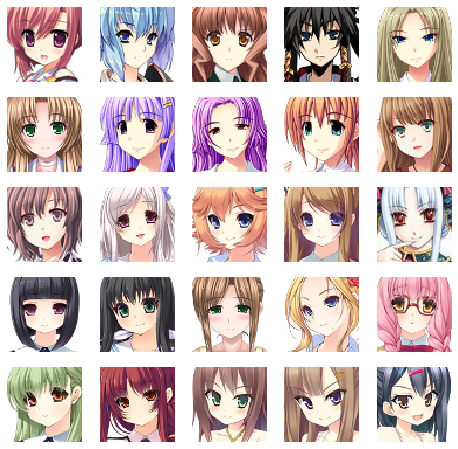

In [5]:
_,ax = plt.subplots(5,5, figsize = (8,8)) 
for i in range(5):
    for j in range(5):
        ax[i,j].imshow(images[5*i+j])
        ax[i,j].axis('off')

## Generative Adversarial Networks

The objective of a GAN is to train a data generator in order to imitate a given dataset.
A GAN is similar to a zero sum game between two neural networks, the generator of data and a discriminator, trained to recognize original data from fakes created by the generator.

<img src="https://skymind.ai/images/wiki/GANs.png" width="800px">

At each step, the discriminator is trained on a batch containing real and fake images. The generator is then trained to produce a batch of images.
<br>**In order to create effective GANs on images, we must use convolutional layers in the discriminator and in the generator.**

In a Deep Convolutional GAN, the data generator has the following structure :

<img src="https://pytorch.org/tutorials/_images/dcgan_generator.png" width="800px">

It takes a noise vector as the input in order to diversify the potential outputs.
<br><br>In a simplified way, after the training each dimension will correspond to a feature of the image, for example the hair shape of the character.

## Creating the GAN

In [6]:
class GAN():
    def __init__(self):
        self.img_shape = (64, 64, 3)
        
        self.noise_size = 100

        optimizer = Adam(0.0002,0.5)

        self.discriminator = self.build_discriminator()
        self.discriminator.compile(loss='binary_crossentropy', 
                                   optimizer=optimizer,
                                   metrics=['accuracy'])

        self.generator = self.build_generator()
        self.generator.compile(loss='binary_crossentropy', optimizer=optimizer)
        
        self.combined = Sequential()
        self.combined.add(self.generator)
        self.combined.add(self.discriminator)
        
        self.discriminator.trainable = False
        
        self.combined.compile(loss='binary_crossentropy', optimizer=optimizer)
        
        self.combined.summary()
        
    # Creating the generator, the large kernels in the convolutional layers allow the network to create complex structures.
    def build_generator(self):
        epsilon = 0.00001 # Small float added to variance to avoid dividing by zero in the BatchNorm layers.
        noise_shape = (self.noise_size,)
        
        model = Sequential()
        
        model.add(Dense(4*4*512, activation='linear', input_shape=noise_shape))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Reshape((4, 4, 512)))
        
        model.add(Conv2DTranspose(512, kernel_size=[4,4], strides=[2,2], padding="same",
                                  kernel_initializer= keras.initializers.TruncatedNormal(stddev=0.02)))
        model.add(BatchNormalization(momentum=0.9, epsilon=epsilon))
        model.add(LeakyReLU(alpha=0.2))
        
        model.add(Conv2DTranspose(256, kernel_size=[4,4], strides=[2,2], padding="same",
                                  kernel_initializer= keras.initializers.TruncatedNormal(stddev=0.02)))
        model.add(BatchNormalization(momentum=0.9, epsilon=epsilon))
        model.add(LeakyReLU(alpha=0.2))
        
        model.add(Conv2DTranspose(128, kernel_size=[4,4], strides=[2,2], padding="same",
                                  kernel_initializer= keras.initializers.TruncatedNormal(stddev=0.02)))
        model.add(BatchNormalization(momentum=0.9, epsilon=epsilon))
        model.add(LeakyReLU(alpha=0.2))
        
        model.add(Conv2DTranspose(64, kernel_size=[4,4], strides=[2,2], padding="same",
                                  kernel_initializer= keras.initializers.TruncatedNormal(stddev=0.02)))
        model.add(BatchNormalization(momentum=0.9, epsilon=epsilon))
        model.add(LeakyReLU(alpha=0.2))
        
        model.add(Conv2DTranspose(3, kernel_size=[4,4], strides=[1,1], padding="same",
                                  kernel_initializer= keras.initializers.TruncatedNormal(stddev=0.02)))

        # Standard activation for the generator of a GAN
        model.add(Activation("tanh"))
        
        model.summary()

        noise = Input(shape=noise_shape)
        img = model(noise)

        return Model(noise, img)

    def build_discriminator(self):

        model = Sequential()

        model.add(Conv2D(128, (3,3), padding='same', input_shape=self.img_shape))
        model.add(LeakyReLU(alpha=0.2))
        model.add(BatchNormalization())
        model.add(Conv2D(128, (3,3), padding='same'))
        model.add(LeakyReLU(alpha=0.2))
        model.add(BatchNormalization())
        model.add(MaxPooling2D(pool_size=(3,3)))
        model.add(Dropout(0.2))

        model.add(Conv2D(128, (3,3), padding='same'))
        model.add(LeakyReLU(alpha=0.2))
        model.add(BatchNormalization())
        model.add(Conv2D(128, (3,3), padding='same'))
        model.add(LeakyReLU(alpha=0.2))
        model.add(BatchNormalization())
        model.add(MaxPooling2D(pool_size=(3,3)))
        model.add(Dropout(0.3))

        model.add(Flatten())
        model.add(Dense(128))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Dense(128))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Dense(1, activation='sigmoid'))
        
        model.summary()
        
        img = Input(shape=self.img_shape)
        validity = model(img)

        return Model(img, validity)

    def train(self, epochs, batch_size=128, save_images=100, save_model=2000):
        
        X_train = np.array(images)
        X_train = (X_train.astype(np.float32) - 127.5) / 127.5

        half_batch = int(batch_size / 2)
        
        mean_d_loss=[0,0]
        mean_g_loss=0

        for epoch in range(epochs):
            idx = np.random.randint(0, X_train.shape[0], half_batch)
            imgs = X_train[idx]

            noise = np.random.normal(0, 1, (half_batch, self.noise_size))
            gen_imgs = self.generator.predict(noise)

            # Training the discriminator
            
            # The loss of the discriminator is the mean of the losses while training on authentic and fake images
            d_loss = 0.5 * np.add(self.discriminator.train_on_batch(imgs, np.ones((half_batch, 1))),
                                  self.discriminator.train_on_batch(gen_imgs, np.zeros((half_batch, 1))))

            # Training the generator
            noise = np.random.normal(0, 1, (batch_size, self.noise_size))

            valid_y = np.array([1] * batch_size)
            g_loss = self.combined.train_on_batch(noise, valid_y)
            
            mean_d_loss[0] += d_loss[0]
            mean_d_loss[1] += d_loss[1]
            mean_g_loss += g_loss
            
            # We print the losses and accuracy of the networks every 200 batches mainly to make sure the accuracy of the discriminator
            # is not stable at around 50% or 100% (which would mean the discriminator performs not well enough or too well)
            if epoch % 200 == 0:
                print ("%d [Discriminator loss: %f, acc.: %.2f%%] [Generator loss: %f]" % (epoch, mean_d_loss[0]/200, mean_d_loss[1]/2, mean_g_loss/200))
                mean_d_loss=[0,0]
                mean_g_loss=0
            losses.append((mean_d_loss[0]/200, mean_g_loss/200))
            

            
            accuracies.append(100.0 * (mean_d_loss[1]/2))
    # Saving 25 generated images to have a representation of the spectrum of images created by the generator
    def save_images(self, epoch):
        noise = np.random.normal(0, 1, (25, self.noise_size))
        gen_imgs = self.generator.predict(noise)
        
        # Rescale from [-1,1] into [0,1]
        gen_imgs = 0.5 * gen_imgs + 0.5

        fig, axs = plt.subplots(5,5, figsize = (8,8))

        for i in range(5):
            for j in range(5):
                axs[i,j].imshow(gen_imgs[5*i+j])
                axs[i,j].axis('off')

        plt.show()
        
        fig.savefig("animeGenerated/Faces_%d.png" % epoch)
        plt.close()

## Training the networks

In [7]:
#This folder will contain the images generated during the training
!mkdir animeGenerated

In [8]:
losses = []
accuracies = []

### Things to keep in mind while training a GAN

**In the case of a GAN, cost functions may not converge using gradient descent.**
<br/>Training a GAN is very different from training a regular neural network. The main difference come from the fact that the discriminator also evolves.
Therefore, the cost function that the generator tries to minimize is also evolving.

**The discriminator must be powerful enough to recognize small differences between the real and fake images.**
<br/>If the discriminator does not perform well, the generator cannot progress.
If the accuracy of the discriminator stabilizes near 50%, the generator already tricks the discriminator well and does not need to improve.

**The two networks must progress in synergy to avoid a diminished gradient during the training of the generator.**
<br/>The discriminator must not be too effective at the beginning, if it is, the generator will not progress until it randomly creates a very convincing image.

We want to avoid **mode collapse** which is when the generator creates the same output no matter the input noise.
It leads to an overfitting from the discriminator which remembers the features of the fake, no matter how convincing it is.

**A high learning rate creates a situation in which both networks overfit to exploit short term opponent weaknesses.**
<br/>The **learning rate** of the optimizer must be carefully chosen.
A high learning rate prevents the generator from reaching a certain level of details, it prevents the convergence.
It also leads to an overfitting from the discriminator which recognizes the most recent features made by the generator but forgets the previous ones.

### Training session

A high batch size leads to a more regular convergence.

We will save the model at the end of the training, we save the architecture of the model, the weights and the state of the optimizer. It allows us to restart the training exactly where we stopped.

In [9]:

gan=GAN()
gan.train(epochs=50001, batch_size=64, save_images=1000, save_model=15000)

Instructions for updating:
If using Keras pass *_constraint arguments to layers.

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 64, 64, 128)       3584      
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 64, 64, 128)       0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 64, 64, 128)       512       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 64, 64, 128)       147584    
_________________________________________________________________
leaky_re_lu_2 (LeakyReLU)    (None, 64, 64, 128)       0         
_________________________________________________________________
batch_normalization_2 (Batch (None, 64, 64, 128)       512       
______________________________________

1800 [Discriminator loss: 0.275739, acc.: 88.40%] [Generator loss: 4.203826]
2000 [Discriminator loss: 0.291326, acc.: 87.85%] [Generator loss: 3.923691]
2200 [Discriminator loss: 0.316158, acc.: 86.45%] [Generator loss: 3.923297]
2400 [Discriminator loss: 0.339207, acc.: 85.61%] [Generator loss: 3.730476]
2600 [Discriminator loss: 0.349459, acc.: 84.86%] [Generator loss: 3.783849]
2800 [Discriminator loss: 0.356804, acc.: 84.23%] [Generator loss: 3.511837]
3000 [Discriminator loss: 0.359032, acc.: 84.03%] [Generator loss: 3.468211]
3200 [Discriminator loss: 0.351494, acc.: 84.77%] [Generator loss: 3.398844]
3400 [Discriminator loss: 0.320843, acc.: 86.07%] [Generator loss: 3.476860]
3600 [Discriminator loss: 0.326671, acc.: 85.70%] [Generator loss: 3.642434]
3800 [Discriminator loss: 0.303021, acc.: 87.11%] [Generator loss: 3.730096]
4000 [Discriminator loss: 0.316967, acc.: 86.34%] [Generator loss: 3.740482]
4200 [Discriminator loss: 0.326336, acc.: 85.88%] [Generator loss: 3.616469]

23000 [Discriminator loss: 0.143790, acc.: 94.18%] [Generator loss: 5.470525]
23200 [Discriminator loss: 0.150341, acc.: 94.33%] [Generator loss: 5.541305]
23400 [Discriminator loss: 0.151665, acc.: 94.00%] [Generator loss: 5.522797]
23600 [Discriminator loss: 0.166993, acc.: 93.72%] [Generator loss: 5.270014]
23800 [Discriminator loss: 0.147024, acc.: 94.09%] [Generator loss: 5.527004]
24000 [Discriminator loss: 0.150606, acc.: 93.98%] [Generator loss: 5.592969]
24200 [Discriminator loss: 0.158116, acc.: 94.08%] [Generator loss: 5.508208]
24400 [Discriminator loss: 0.140117, acc.: 94.77%] [Generator loss: 5.327064]
24600 [Discriminator loss: 0.148869, acc.: 94.30%] [Generator loss: 5.303359]
24800 [Discriminator loss: 0.153636, acc.: 93.98%] [Generator loss: 5.416399]
25000 [Discriminator loss: 0.153296, acc.: 94.21%] [Generator loss: 5.552026]
25200 [Discriminator loss: 0.160122, acc.: 93.85%] [Generator loss: 5.327133]
25400 [Discriminator loss: 0.155641, acc.: 94.02%] [Generator lo

44200 [Discriminator loss: 0.104378, acc.: 96.18%] [Generator loss: 5.665942]
44400 [Discriminator loss: 0.105632, acc.: 95.92%] [Generator loss: 6.104655]
44600 [Discriminator loss: 0.122344, acc.: 95.41%] [Generator loss: 5.999749]
44800 [Discriminator loss: 0.131403, acc.: 95.25%] [Generator loss: 5.788194]
45000 [Discriminator loss: 0.104610, acc.: 95.91%] [Generator loss: 6.030529]
45200 [Discriminator loss: 0.107202, acc.: 95.95%] [Generator loss: 6.043324]
45400 [Discriminator loss: 0.124575, acc.: 95.42%] [Generator loss: 5.838947]
45600 [Discriminator loss: 0.124623, acc.: 95.19%] [Generator loss: 5.999261]
45800 [Discriminator loss: 0.106102, acc.: 95.79%] [Generator loss: 6.167562]
46000 [Discriminator loss: 0.110916, acc.: 96.10%] [Generator loss: 6.012271]
46200 [Discriminator loss: 0.125530, acc.: 95.50%] [Generator loss: 6.006354]
46400 [Discriminator loss: 0.098670, acc.: 96.27%] [Generator loss: 5.996307]
46600 [Discriminator loss: 0.115133, acc.: 95.59%] [Generator lo

In [156]:
from __future__ import print_function
import os 
import cv2
import numpy as np
from scipy.stats import norm

from keras.layers import Input, Dense, Lambda, Reshape
from keras.models import Model
from keras import backend as K   # This is Keras Backend. i.e. Tensorflow.
from keras import metrics
from keras.datasets import mnist
batch_size       = 100
epochs           = 50

original_dim     = 28*28  # Original image dimensions 28x28
latent_dim       = 100   # Dimensions of the Latent space
intermediate_dim = 256  # Number of neurons in the single-hidden layer

epsilon_std      = 1.0  # Standard Deviation

In [157]:
def sampling(args: tuple):
    z_mean, z_log_var = args  # explode the variables from the tuple
    epsilon = K.random_normal(shape=(K.shape(z_mean)[0], latent_dim), 
                              mean=0.,
                              stddev=epsilon_std)
    return z_mean + K.exp(z_log_var / 2) * epsilon
# input to our encoder
x = Input(shape=(original_dim,), name="input")  #  is used to instantiate a Keras tensor.

# intermediate layer
h = Dense(intermediate_dim, activation='relu', name="encoding")(x)  #Uses the tensor X as input

# defining the mean of the latent space
z_mean = Dense(latent_dim, name="mean")(h)              #connects the "Encoding" Layer Output 
                                                        # Tensor to a new Layer

# defining the log variance of the latent space
z_log_var = Dense(latent_dim, name="log-variance")(h)   #connects the "Encoding" Layer Output 
                                                        # Tensor to a new Layer

# LATENT Space
z = Lambda(sampling, 
           output_shape=(latent_dim,),
           name="LatentSpace")([z_mean, z_log_var])   # z is a tensor representing 
                                                                        # the latent space
# defining the encoder as a keras model
encoder = Model(inputs = x, 
                outputs = [z_mean, z_log_var, z], 
                name="encoder")  

encoder.summary()

Model: "encoder"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input (InputLayer)              (None, 784)          0                                            
__________________________________________________________________________________________________
encoding (Dense)                (None, 256)          200960      input[0][0]                      
__________________________________________________________________________________________________
mean (Dense)                    (None, 100)          25700       encoding[0][0]                   
__________________________________________________________________________________________________
log-variance (Dense)            (None, 100)          25700       encoding[0][0]                   
____________________________________________________________________________________________

In [158]:
# Input to the decoder
input_decoder = Input(shape=(latent_dim,), name="decoder_input")

# taking the latent space to intermediate dimension
decoder_h = Dense(intermediate_dim, activation='relu', name="decoder_h")(input_decoder)

# getting the mean from the original dimension
x_decoded = Dense(original_dim, activation='sigmoid', name="flat_decoded")(decoder_h)

# defining the decoder as a keras model
decoder = Model(inputs = input_decoder, 
                outputs = x_decoded, 
                name="decoder")
decoder.summary()

Model: "decoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
decoder_input (InputLayer)   (None, 100)               0         
_________________________________________________________________
decoder_h (Dense)            (None, 256)               25856     
_________________________________________________________________
flat_decoded (Dense)         (None, 784)               201488    
Total params: 227,344
Trainable params: 227,344
Non-trainable params: 0
_________________________________________________________________


In [159]:
# The VAE will 
# 1) encode an example,
# 2) Using the latent space (3rd element of our sampling, 'z')
# 3) Decode using that Latent Space. 
output_combined = decoder(encoder(x)[2])


vae = Model(inputs  = x,                # the original inputs, i.e. the real dataset
            outputs = output_combined,  # The decoded through the VAE
            name = "VAE")


vae.summary()

Model: "VAE"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           (None, 784)               0         
_________________________________________________________________
encoder (Model)              [(None, 100), (None, 100) 252360    
_________________________________________________________________
decoder (Model)              (None, 784)               227344    
Total params: 479,704
Trainable params: 479,704
Non-trainable params: 0
_________________________________________________________________


In [160]:
def vae_loss(x: tf.Tensor, 
             x_decoded_mean: tf.Tensor,
             z_log_var    = z_log_var, 
             z_mean       = z_mean,
             original_dim = original_dim
            ):
    
    xent_loss = original_dim * metrics.binary_crossentropy(x, x_decoded_mean)
    
    kl_loss = - 0.5 * K.sum(1 + z_log_var - K.square(z_mean) - K.exp(z_log_var), axis=-1)
    
    vae_loss = K.mean(xent_loss + kl_loss)
    
    return vae_loss

In [161]:
vae.compile(optimizer='rmsprop', loss=vae_loss)  #we use our customized loss function
vae.summary()

Model: "VAE"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           (None, 784)               0         
_________________________________________________________________
encoder (Model)              [(None, 100), (None, 100) 252360    
_________________________________________________________________
decoder (Model)              (None, 784)               227344    
Total params: 479,704
Trainable params: 479,704
Non-trainable params: 0
_________________________________________________________________


In [162]:
(x_train, y_train), (x_test, y_test) = mnist.load_data()
xt=x_test/255
x_train = x_train  / 255.
x_test  = x_test  / 255.
print ("Initial Data Shape:",x_train[0].shape)

#From matrix to array
x_train = x_train.reshape((len(x_train), np.prod(x_train.shape[1:]))) 
x_test  = x_test.reshape ((len(x_test),  np.prod(x_test.shape[1:] )))
print ("Final  Data Shape: ",x_train[0].shape)

Initial Data Shape: (28, 28)
Final  Data Shape:  (784,)


In [203]:
history = vae.fit(x_train, x_train,
                  shuffle         = True,          # shuffles the dataset to avoid any issue with pre-order
                  epochs          = 1000,
                  batch_size      = batch_size,
                  validation_data = (x_test,y_test))


Train on 60000 samples, validate on 10000 samples
Epoch 1/1000
60000/60000 [==============================] - 2s 38us/step - loss: 105.2005 - val_loss: 134825.0910
Epoch 2/1000
60000/60000 [==============================] - 2s 37us/step - loss: 105.2555 - val_loss: 140005.7427
Epoch 3/1000
60000/60000 [==============================] - 2s 38us/step - loss: 105.2650 - val_loss: 136989.4970
Epoch 4/1000
60000/60000 [==============================] - 2s 37us/step - loss: 105.2485 - val_loss: 136479.1054
Epoch 5/1000
60000/60000 [==============================] - 2s 36us/step - loss: 105.2186 - val_loss: 134167.0182
Epoch 6/1000
60000/60000 [==============================] - 2s 35us/step - loss: 105.2340 - val_loss: 132799.1633
Epoch 7/1000
60000/60000 [==============================] - 2s 36us/step - loss: 105.2573 - val_loss: 130899.2360
Epoch 8/1000
60000/60000 [==============================] - 2s 37us/step - loss: 105.2406 - val_loss: 139185.8848
Epoch 9/1000
60000/60000 [============

Epoch 72/1000
60000/60000 [==============================] - 2s 36us/step - loss: 105.3192 - val_loss: 132558.0581
Epoch 73/1000
60000/60000 [==============================] - 2s 36us/step - loss: 105.2804 - val_loss: 132898.5645
Epoch 74/1000
60000/60000 [==============================] - 2s 36us/step - loss: 105.2960 - val_loss: 129261.2520
Epoch 75/1000
60000/60000 [==============================] - 2s 36us/step - loss: 105.3380 - val_loss: 138096.3160
Epoch 76/1000
60000/60000 [==============================] - 2s 36us/step - loss: 105.3379 - val_loss: 137077.9783
Epoch 77/1000
60000/60000 [==============================] - 2s 36us/step - loss: 105.3776 - val_loss: 138806.6263
Epoch 78/1000
60000/60000 [==============================] - 2s 36us/step - loss: 105.3129 - val_loss: 135734.9755
Epoch 79/1000
60000/60000 [==============================] - 2s 36us/step - loss: 105.3393 - val_loss: 138346.0772
Epoch 80/1000
60000/60000 [==============================] - 2s 35us/step - loss

Epoch 143/1000
60000/60000 [==============================] - 2s 35us/step - loss: 105.3845 - val_loss: 141234.6109
Epoch 144/1000
60000/60000 [==============================] - 2s 35us/step - loss: 105.4211 - val_loss: 140417.6988
Epoch 145/1000
60000/60000 [==============================] - 2s 35us/step - loss: 105.3940 - val_loss: 139106.9534
Epoch 146/1000
60000/60000 [==============================] - 2s 35us/step - loss: 105.4245 - val_loss: 131649.6680
Epoch 147/1000
60000/60000 [==============================] - 2s 35us/step - loss: 105.3921 - val_loss: 134183.6264
Epoch 148/1000
60000/60000 [==============================] - 2s 35us/step - loss: 105.4233 - val_loss: 141710.8618
Epoch 149/1000
60000/60000 [==============================] - 2s 35us/step - loss: 105.4422 - val_loss: 140133.9420
Epoch 150/1000
60000/60000 [==============================] - 2s 35us/step - loss: 105.4447 - val_loss: 136500.9262
Epoch 151/1000
60000/60000 [==============================] - 2s 35us/st

Epoch 284/1000
60000/60000 [==============================] - 2s 35us/step - loss: 105.5671 - val_loss: 139432.4603
Epoch 285/1000
60000/60000 [==============================] - 2s 34us/step - loss: 105.5575 - val_loss: 141645.9416
Epoch 286/1000
60000/60000 [==============================] - 2s 34us/step - loss: 105.5717 - val_loss: 140907.9369
Epoch 287/1000
60000/60000 [==============================] - 2s 34us/step - loss: 105.5911 - val_loss: 140015.9199
Epoch 288/1000
60000/60000 [==============================] - 2s 34us/step - loss: 105.6009 - val_loss: 141486.8278
Epoch 289/1000
60000/60000 [==============================] - 2s 34us/step - loss: 105.5992 - val_loss: 143170.1452
Epoch 290/1000
60000/60000 [==============================] - 2s 34us/step - loss: 105.5741 - val_loss: 138600.6889
Epoch 291/1000
60000/60000 [==============================] - 2s 35us/step - loss: 105.5546 - val_loss: 141062.4233
Epoch 292/1000
60000/60000 [==============================] - 2s 35us/st

60000/60000 [==============================] - 2s 36us/step - loss: 105.7024 - val_loss: 148548.9848
Epoch 425/1000
60000/60000 [==============================] - 2s 36us/step - loss: 105.6983 - val_loss: 142608.6009
Epoch 426/1000
60000/60000 [==============================] - 2s 35us/step - loss: 105.7200 - val_loss: 143758.7255
Epoch 427/1000
60000/60000 [==============================] - 2s 34us/step - loss: 105.7130 - val_loss: 145838.2023
Epoch 428/1000
60000/60000 [==============================] - 2s 34us/step - loss: 105.6980 - val_loss: 143626.0007
Epoch 429/1000
60000/60000 [==============================] - 2s 34us/step - loss: 105.6875 - val_loss: 146300.7009
Epoch 430/1000
60000/60000 [==============================] - 2s 35us/step - loss: 105.6887 - val_loss: 140242.0433
Epoch 431/1000
60000/60000 [==============================] - 2s 34us/step - loss: 105.6419 - val_loss: 137032.6691
Epoch 432/1000
60000/60000 [==============================] - 2s 35us/step - loss: 105.

Epoch 495/1000
60000/60000 [==============================] - 2s 35us/step - loss: 105.7679 - val_loss: 146864.1263
Epoch 496/1000
60000/60000 [==============================] - 2s 35us/step - loss: 105.7357 - val_loss: 146616.2911
Epoch 497/1000
60000/60000 [==============================] - 2s 35us/step - loss: 105.7826 - val_loss: 143972.8663
Epoch 498/1000
60000/60000 [==============================] - 2s 36us/step - loss: 105.7962 - val_loss: 144303.1052
Epoch 499/1000
60000/60000 [==============================] - 2s 35us/step - loss: 105.7546 - val_loss: 137229.2480
Epoch 500/1000
60000/60000 [==============================] - 2s 37us/step - loss: 105.7679 - val_loss: 149884.1730
Epoch 501/1000
60000/60000 [==============================] - 2s 35us/step - loss: 105.7962 - val_loss: 144508.3789
Epoch 502/1000
60000/60000 [==============================] - 2s 36us/step - loss: 105.7889 - val_loss: 140016.8216
Epoch 503/1000
60000/60000 [==============================] - 2s 36us/st

Epoch 636/1000
60000/60000 [==============================] - 2s 35us/step - loss: 105.8822 - val_loss: 149804.8181
Epoch 637/1000
60000/60000 [==============================] - 2s 36us/step - loss: 105.8411 - val_loss: 154524.4923
Epoch 638/1000
60000/60000 [==============================] - 2s 36us/step - loss: 105.9263 - val_loss: 140194.1572
Epoch 639/1000
60000/60000 [==============================] - 2s 36us/step - loss: 105.8779 - val_loss: 149009.5944
Epoch 640/1000
60000/60000 [==============================] - 2s 37us/step - loss: 105.8844 - val_loss: 144348.9423
Epoch 641/1000
60000/60000 [==============================] - 2s 36us/step - loss: 105.8914 - val_loss: 147992.0986
Epoch 642/1000
60000/60000 [==============================] - 2s 37us/step - loss: 105.9020 - val_loss: 149695.3373
Epoch 643/1000
60000/60000 [==============================] - 2s 35us/step - loss: 105.9214 - val_loss: 140021.0612
Epoch 644/1000
60000/60000 [==============================] - 2s 36us/st

Epoch 777/1000
60000/60000 [==============================] - 2s 36us/step - loss: 105.9679 - val_loss: 151824.5423
Epoch 778/1000
60000/60000 [==============================] - 2s 35us/step - loss: 105.9932 - val_loss: 156259.8559
Epoch 779/1000
60000/60000 [==============================] - 2s 34us/step - loss: 105.9651 - val_loss: 150879.5070
Epoch 780/1000
60000/60000 [==============================] - 2s 34us/step - loss: 105.9504 - val_loss: 156207.8746
Epoch 781/1000
60000/60000 [==============================] - 2s 37us/step - loss: 106.0155 - val_loss: 153645.3228
Epoch 782/1000
60000/60000 [==============================] - 2s 35us/step - loss: 105.9803 - val_loss: 154039.0091
Epoch 783/1000
60000/60000 [==============================] - 2s 37us/step - loss: 105.9916 - val_loss: 152340.0778
Epoch 784/1000
60000/60000 [==============================] - 2s 36us/step - loss: 105.9851 - val_loss: 152455.7027
Epoch 785/1000
60000/60000 [==============================] - 2s 35us/st

Epoch 918/1000
60000/60000 [==============================] - 2s 38us/step - loss: 106.0845 - val_loss: 158508.9517
Epoch 919/1000
60000/60000 [==============================] - 2s 34us/step - loss: 106.0419 - val_loss: 153986.5037
Epoch 920/1000
60000/60000 [==============================] - 2s 36us/step - loss: 106.0758 - val_loss: 153011.6728
Epoch 921/1000
60000/60000 [==============================] - 2s 38us/step - loss: 106.0748 - val_loss: 148305.8028
Epoch 922/1000
60000/60000 [==============================] - 2s 36us/step - loss: 106.0636 - val_loss: 151019.8706
Epoch 923/1000
60000/60000 [==============================] - 2s 36us/step - loss: 106.0564 - val_loss: 152990.1052
Epoch 924/1000
60000/60000 [==============================] - 2s 36us/step - loss: 106.0502 - val_loss: 157556.2765
Epoch 925/1000
60000/60000 [==============================] - 2s 36us/step - loss: 106.0407 - val_loss: 154853.2705
Epoch 926/1000
60000/60000 [==============================] - 2s 35us/st

In [18]:
def list_images(basePath, contains=None):
    # return the set of files that are valid
    return list_files(basePath, validExts=(".jpg", ".jpeg", ".png", ".bmp"), contains=contains)

def list_files(basePath, validExts=(".jpg", ".jpeg", ".png", ".bmp"), contains=None):
    # loop over the directory structure
    for (rootDir, dirNames, filenames) in os.walk(basePath):
        # loop over the filenames in the current directory
        for filename in filenames:
            # if the contains string is not none and the filename does not contain
            # the supplied string, then ignore the file
            if contains is not None and filename.find(contains) == -1:
                continue

            # determine the file extension of the current file
            ext = filename[filename.rfind("."):].lower()

            # check to see if the file is an image and should be processed
            if ext.endswith(validExts):
                # construct the path to the image and yield it
                imagePath = os.path.join(rootDir, filename).replace(" ", "\\ ")
                yield imagePath
                
def load_images(directory='', size=(28,28)):
    images = []
    labels = []  # Integers corresponding to the categories in alphabetical order
    label = 0
    
    imagePaths = list(list_images(directory))
    
    for path in imagePaths:
        
        if not('OSX' in path):
        
            path = path.replace('\\','/')

            image = cv2.imread(path) #Reading the image with OpenCV
            image = cv2.resize(image,size) #Resizing the image, in case some are not of the same size
    
            images.append(cv2.cvtColor(image, cv2.COLOR_BGR2GRAY))
    
    return images

In [189]:
images=load_images('./test')
images=np.array(images)

# Here are the photos we are going to pass through the encoder to get the latent space

I decided to use a picture of myself, two my close friends and a korean actor. I tried to pass pictures that were slightly different from each other to test my encoder

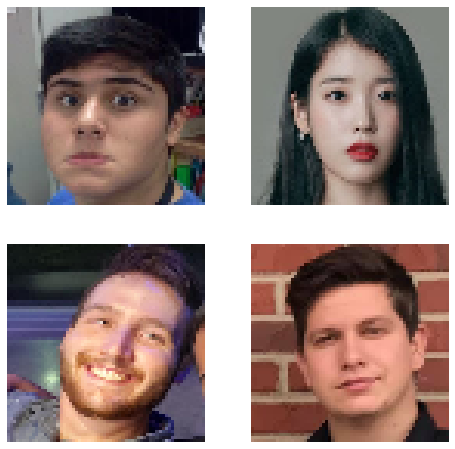

In [146]:
images=load_images1('./test')
fig, axs = plt.subplots(2,2, figsize = (8,8))

for i in range(2):
    for j in range(2):
        axs[i,j].imshow(images[2*i+j])
        axs[i,j].axis('off')
plt.show()       
plt.close()

In [190]:
print(len(images))
images= images  / 255.

4


In [199]:
images= images.reshape((len(images), np.prod(images.shape[1:]))) 

In [200]:
x_t= encoder.predict(images, batch_size=4)[0]
len(x_t[1])

100

In [201]:
ge_imgs = gan.generator.predict(x_t)

print(len(ge_imgs[1]))

64


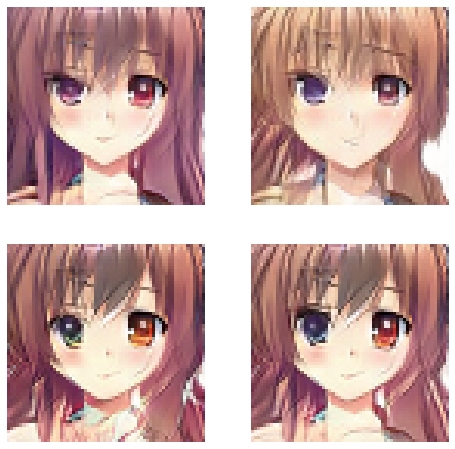

In [202]:
ge_imgs = 0.5 * ge_imgs + 0.5
fig, axs = plt.subplots(2,2, figsize = (8,8))

for i in range(2):
    for j in range(2):
        axs[i,j].imshow(ge_imgs[2*i+j])
        axs[i,j].axis('off')
plt.show()       
plt.close()

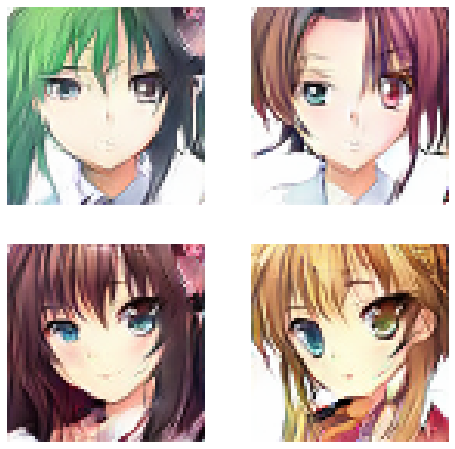

In [197]:

noisee = np.random.normal(0, 1, (1,100))

type(noisee)
noisee = np.random.normal(0, 1
                          , (4,100))
ge_imgs = gan.generator.predict(noisee)
ge_imgs = 0.5 * ge_imgs + 0.5


fig, axs = plt.subplots(2,2, figsize = (8,8))

for i in range(2):
    for j in range(2):
        axs[i,j].imshow(ge_imgs[2*i+j])
        axs[i,j].axis('off')
plt.show()       
plt.close()